In [1]:
using Plots
include("polyfit_function.jl")
include("Lagrange_interpolation.jl")
include("LReg.jl")
include("Lagrange_Mat.jl")

Lagrange_Mat (generic function with 1 method)

# Advection Equation

\begin{align}
  \frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x}, &= 0,
  \quad x\in[0,1], \quad t\in(0,T],\\
  u(t,0) &= u(t,1)=0, \quad u(0,x) = exp(-200*(x-0.25)^2).
\end{align}

Discretizing by implicit Upwind gives

\begin{align*}
  \frac{u^{n+1}_i - u^{n}_i}{\Delta t} = -c
  \frac{u^{n+1}_{i} - u^{n+1}_{i-1}}{\Delta x}
\end{align*}

In [3]:
function rs(u,dx)
    # approximates D u
    n = length(u)
    c=1.0
    alpha= c / dx
    D = Array(Tridiagonal(fill(alpha, n-1), fill(-alpha, n),fill(0.0,n-1)))
    
    return D*u
end

rs (generic function with 1 method)

# Reference solution with coarsening factor m=2

In [5]:
# Reference Solution for m=3
function Ref2D(tspan, u0, dx, dt, N)
    
    M=length(u0)
    m=2 # Coarsenning factor
    t=(0:N)*dt
    DT1=m*dt
    DT2= m*DT1
    U=zeros(M, N+1, 3)
    
    U[:, 1, 1]=u0
    U[:, 1, 2]=u0
    U[:, 1, 3]=u0

    c = 1.0
    beta = c * (dt / dx)
    A = Array(Tridiagonal(fill(-beta, M-1), fill(1 + beta, M), fill(0.0, M-1)))
    
    bet = c/dx
    D = Array(Tridiagonal(fill(bet,M-1),fill(-bet,M),fill(0.0,M-1)))
    I_ex=I(M)

    for i=1:m^2:N # Level 3 loop
        U[:, i, 2]=U[:, i, 3] # Injection from the third level
        
        for j= i:m:i+2 # Level 2 loop
            
            U[:, j, 1]=U[:, j, 2] # Injection from the second level
            
            for k=j:j+1 # Level 1 loop
                U[:, k+1, 1]= A \ U[:, k, 1]
            end
                
            # Right-hand-side function value
            rs_n1 = D*U[:, j, 1]      
            rs_n2 = D*U[:, j+1, 1]
            rs_n3 = D*U[:, j+2, 1]
            
            
            # Perform Lagrange interpolation 
            rs_values1 = hcat(rs_n1, rs_n2, rs_n3)  
        
            #quad_approx1 = Lagrange_Mat(t[j:j+2], rs_values1, t[j], t[j+2])

            quad_approx1 = DT1* ((1/6) .* rs_n1 .+ (2/3) .* rs_n2 .+ (1/6) .* rs_n3)


            # Assemble the right-hand side for the correction
            f1 = U[:, j, 2] .- DT1 .* D*U[:, j+m, 1] .+ quad_approx1  # Right-hand side IDC for ut=uxx
            
            # Needs to redefine Matrix A for the coarse system 
            c = 1.0
            beta1 = c * (DT1 / dx) # DT
            B1 = Array(Tridiagonal(fill(-beta1, M-1), fill(1 + beta1, M), fill(0.0, M-1)))
            
            #B1= (I_ex .- DT1*D) # That's my alpha1 (for a scalar system)
            U[:, j+m, 2] = B1 \ f1
        end
        # Right-hand-side function value
        rs2_n1 = D*U[:, i, 2]      
        rs2_n2 = D*U[:, i+m, 2]
        rs2_n3 = D*U[:, i+2*m, 2]
            

        # Perform Lagrange interpolation 
         rs_values2 = hcat(rs2_n1, rs2_n2, rs2_n3)  # Matrix of residuals (M, 3)
        
        #quad_approx = Lagrange_Mat(t[i:m:i+m^2], rs_values2, t[i], t[i+m^2])

        quad_approx2 = DT2* ((1/6) .* rs2_n1 .+ (2/3) .* rs2_n2 .+ (1/6) .* rs2_n3)

        # Assemble the right-hand side for the correction
        f2 = U[:, i, 3] .- DT2 .* D*U[:, i+m^2, 2] .+ quad_approx2  # Right-hand side IDC for ut=uxx
            
        # Needs to redefine Matrix A for the coarse system 
        
        beta2 = c * (DT2 / dx) 
        
        B2 = Array(Tridiagonal(fill(-beta2, M-1), fill(1 + beta2, M), fill(0.0, M-1)))

        #B2=(I_ex .- DT2*D) # that's my alpha2 for the scalar system!!
        
        U[:, i+m^2, 3] = B2 \ f2
    end
    return U
end

Ref2D (generic function with 1 method)

In [ ]:
# Convergence Study in time for the two-level Reference Solution

X = 150  # number of (interior) spatial grid points
tspan = [0 1.0]
dx = 1.0 / (X + 1)
x = (1:X) .* dx
u0 = exp.(-200*(x .- 0.25).^2)

K = 6
err = zeros(K-1)  # we will compare successive solutions
nstore = zeros(K-1, 1)
u_store = zeros(X, K)

for k in 1:K
    
    N = 8^k # number of time intervals
    #nstore[k]= N
    dt = (tspan[2] - tspan[1]) / N
    
    u =Ref2D(tspan, u0, dx, dt, N)
    
    # Store only the final state for each k
    u_store[:, k] = u[:, end, 3]
end

# Calculate errors
for k in 2:K
    err[k-1] = norm(u_store[:, k] - u_store[:, k-1]) + 10^(-16)
    nstore[k-1] = 8^(k-1)  # Store N values for analysis
end

# Polyfit
pdeg = polyfit(log10.(nstore[:]),log10.(err[:]),1)
print("convergence order = ",abs(pdeg[2]), "\n")

plot(nstore,err[:],xaxis=:log,yaxis=:log,xlabel="N",ylabel="error",label="Reference Solution")

#### Approximate Solution with coarsening factor m=2

In [ ]:
function iter2D(tspan, u0, dx, dt, N, K)

    M=length(u0)
    m=2 # Coarsenning factor
    DT1=m*dt
    DT2= m*DT1
    t=(0:N)*dt
    u=zeros(M, N+1, K+1)
    uc=zeros(M, N+1, K+1)
    u[:, 1, 1]=u0
    uc[:, 1, 1]=u0
    ps1=3:m:N
    ps2=5:m^2:N
    uc[:, ps1, 1]= ones(M, length(ps1))
    u[:, ps2, 1]= ones(M, length(ps2))
    up = zeros(M, N + 1)
    up[:, 1]= u0
    # Set up of Matrix A for the fine mesh
    c = 1.0
    
    for k in 1:K
    
        u[:, 1, k+1]=u0
        uc[:, 1, k+1]=u0

        beta = c * (dt / dx)
        A = Array(Tridiagonal(fill(-beta, M-1), fill(1 + beta, M), fill(0.0, M-1)))

        alpha1=c/ dx
        D=Array(Tridiagonal(fill(alpha1,M-1),fill(-alpha1,M),fill(0.0,M-1)))
        
        # Level-1 fine solution

        for i=1:m:N
            up[:, i]=uc[:, i, k] # injection from Level-2
            up[:, i+1]= A\up[:, i]
        end

        for j=2:m:N
            up[:, j+1]= A\up[:, j]
        end


        # Level-2 first coarse solution
        # let's redefine A
       
        beta1 = c * (DT1 / dx) # DT
        A1 = Array(Tridiagonal(fill(-beta1, M-1), fill(1 + beta1, M), fill(0.0, M-1)))
        
        for n=1:m^2:N

            uc[:, n, k+1]=u[:, n, k] # injection from the Level-3
            
            rs1_n1= D*u[:, n, k]
            rs1_n2= D*up[:, n+1]
            rs1_n3= D*up[:, n+2]
            
            
            rs_values1 = hcat(rs1_n1, rs1_n2, rs1_n3)
            
            #quad_approx1= Lagrange_Mat(t[n:n+3], rs_values1, t[n], t[n+3])

           quad_approx1= DT1*D*((1/6)* u[:, n, k]  .+ (2/3)* up[:, n+1]  .+ (1/6)* up[:, n+2])

            
            f1 = uc[:, n, k+1] .- DT1 *D*up[:, n+2] .+ quad_approx1

            uc[:, n+m, k+1]= A1 \ f1
        end

        for p=3:m^2:N
            rs1_p1= D*uc[:, p, k]
            rs1_p2= D*up[:, p+1]
            rs1_p3= D*up[:, p+2]
            
            rs_values2 = hcat(rs1_p1, rs1_p2, rs1_p3)
            
            #quad_approx2 = Lagrange_Mat(t[p:p+m], rs_values2, t[p], t[p+2])
            quad_approx2= DT1*D*((1/6)* uc[:, p, k] .+ (2/3)* up[:, p+1]  .+ (1/6)* up[:, p+2])

            f2= uc[:, p, k+1] .- DT1 *D*up[:, p+m] .+ quad_approx2

            uc[:, p+m, k+1]= A1 \ f2
        end

        
        # Sequential Level-3

        for z=1:m^2:N

            uc[:, z, k+1]=u[:, z, k]
            
            rs_z1= D*uc[:, z, k+1]
            rs_z2= D*uc[:, z+m, k+1]
            rs_z3= D*uc[:, z+2*m,  k+1]
           
            
            #quad_approx3 = Lagrange_Mat(t[z:m:z+m^2], rs_values4, t[z], t[z+m^2])

            quad_approx3= DT2*D*((1/6)* uc[:, z, k+1]+ (2/3)*uc[:, z+m, k+1] .+ (1/6)*uc[:, z+2*m,  k+1])
            
            
            beta2 = c * (DT2 / dx) # DT
            B = Array(Tridiagonal(fill(-beta2, M-1), fill(1 + beta2, M), fill(0.0, M-1)))

            f3= u[:, z, k+1] .- DT2 .* D*uc[:, z+m^2, k+1] .+ quad_approx3

            u[:, z+m^2, k+1]= B \ f3
        end
    end

    return u
end

In [ ]:
# Convergence Study in time for the two-level Reference Solution

X = 150  # number of (interior) spatial grid points
tspan = [0 1.0]
dx = 1.0 / (X + 1)
x = (1:X) .* dx
u0 = exp.(-200*(x .- 0.25).^2)

K = 6
err = zeros(K-1)  # we will compare successive solutions
nstore = zeros(K-1, 1)
u_store = zeros(X, K)

for k in 1:K
    
    N = 8^k  # number of time intervals
    #nstore[k]= N
    dt = (tspan[2] - tspan[1]) / N
    
    u =iter2D(tspan, u0, dx, dt, N, 30)
    
    # Store only the final state for each k
    u_store[:, k] = u[:, end, end]
end

# Calculate errors
for k in 2:K
    err[k-1] = norm(u_store[:, k] - u_store[:, k-1]) + 10^(-16)
    nstore[k-1] = 8^(k-1)  # Store N values for analysis
end

# Polyfit
pdeg = polyfit(log10.(nstore[:]),log10.(err[:]),1)
print("convergence order = ",abs(pdeg[2]), "\n")

plot(nstore,err[:],xaxis=:log,yaxis=:log,xlabel="N",ylabel="error",label="Approximate Solution")

In [ ]:
X = 100   # number of (interior) spatial grid points
dx = 1.0 / (X + 1)
x = (1:X) .* dx
u0 = exp.(-200*(x .- 0.25).^2)
m=2
tspan = [0 1.0]
N=100
dt=(tspan[2]-tspan[1])/N
K=55
err=zeros(K+1)
U=Ref2D(tspan, u0, dx, dt, N)
u=iter2D(tspan, u0, dx, dt, N, K)
for k=1:K+1
    err[k] = norm(U[:, 1:m:end, 3] .- u[:, 1:m:end, k]) .+10^(-16)
end
plot(0:K, err, yaxis=:log, label="Finite step convergence for Advection, m=2, N=100")

# Reference solution with coarsening factor m=3

In [ ]:
# Reference Solution for m=3
function Ref3D(tspan, u0, dx, dt, N)
    
    M=length(u0)
    m=3 # Coarsenning factor
    t=(0:N)*dt
    DT1=m*dt
    DT2= m*DT1
    U=zeros(M, N+1, 3)
    
    U[:, 1, 1]=u0
    U[:, 1, 2]=u0
    U[:, 1, 3]=u0

    c = 1.0
    beta = c * (dt / dx)
    A = Array(Tridiagonal(fill(-beta, M-1), fill(1 + beta, M), fill(0.0, M-1)))
    bet = c/ dx
    D = Array(Tridiagonal(fill(bet, M-1), fill(-bet,M), fill(0.0, M-1)))
    I_ex=I(M)

    for i=1:m^2:N # Level 3 loop
        U[:, i, 2]=U[:, i, 3] # Injection from the third level
        
        for j= i:m:i+6 # Level 2 loop
            
            U[:, j, 1]=U[:, j, 2] # Injection from the second level
            
            for k=j:j+2 # Level 1 loop
                U[:, k+1, 1]= A \ U[:, k, 1]
            end
                
            # Right-hand-side function value
            rs_n1 = rs(U[:, j, 1], dx)      
            rs_n2 = rs(U[:, j+1, 1], dx) 
            rs_n3 = rs(U[:, j+2, 1], dx)
            rs_n4 = rs(U[:, j+3, 1], dx)
            
            # Perform Lagrange interpolation 
            rs_values = hcat(rs_n1, rs_n2, rs_n3, rs_n4)  
        
            #quad_approx = Lagrange_Mat(t[j:j+3], rs_values, t[j], t[j+3])

            quad_approx = DT1* ((1/8) .* rs_n1 .+ (3/8) .* rs_n2 .+ (3/8) .* rs_n3 .+ (1/8) .* rs_n4)


            # Assemble the right-hand side for the correction
            f = U[:, j, 2] .- DT1 .* rs(U[:, j+m, 1], dx) .+ quad_approx  # Right-hand side IDC for ut=uxx
            
            # Needs to redefine Matrix A for the coarse system 
            c = 1.0
            beta1 = c* (DT1 / dx) # DT
            B1 = Array(Tridiagonal(fill(-beta1, M-1), fill(1 + beta1, M), fill(0.0, M-1)))
            
            #B1= (I_ex .- DT1*D) # That's my alpha1 (for a scalar system)
            U[:, j+m, 2] = B1 \ f
        end
        # Right-hand-side function value
            rs2_n1 = rs(U[:, i, 2], dx)      
            rs2_n2 = rs(U[:, i+3, 2], dx) 
            rs2_n3 = rs(U[:, i+6, 2], dx)
            rs2_n4 = rs(U[:, i+9, 2], dx)

            # Perform Lagrange interpolation 
            rs_values = hcat(rs2_n1, rs2_n2, rs2_n3, rs2_n4)  # Matrix of residuals (M, 3)
        
            #quad_approx = Lagrange_Mat(t[i:m:i+m^2], rs_values, t[i], t[i+m^2])

            quad_approx = DT2* ((1/8) .* rs2_n1 .+ (3/8) .* rs2_n2 .+ (3/8) .* rs2_n3 .+ (1/8) .* rs2_n4)

            # Assemble the right-hand side for the correction
            f = U[:, i, 3] .- DT2 .* rs(U[:, i+m^2, 2], dx) .+ quad_approx  # Right-hand side IDC for ut=uxx
            
            # Needs to redefine Matrix A for the coarse system 
            c= 1.0
            beta2 =  (c*DT2 )/ dx 
            B2 = Array(Tridiagonal(fill(-beta2, M-1), fill(1 + beta2, M), fill(0.0, M-1)))

            #B2=(I_ex .- DT2*D) # that's my alpha2 for the scalar system!!
        
            U[:, i+m^2, 3] = B2 \ f
    end
    return U
end

In [ ]:
# Convergence Study in time for the two-level Reference Solution

X = 100  # number of (interior) spatial grid points
tspan = [0 1.0]
dx = 1.0 / (X + 1)
x = (1:X) .* dx
u0 = exp.(-200*(x .- 0.25).^2)

K = 11
err = zeros(K-1)  # we will compare successive solutions
nstore = zeros(K-1, 1)
u_store = zeros(X, K)

for k in 1:K
    
    N = 9* 2^k # number of time intervals
    #nstore[k]= N
    dt = (tspan[2] - tspan[1]) / N
    
    u =Ref3D(tspan, u0, dx, dt, N)
    
    # Store only the final state for each k
    u_store[:, k] = u[:, end, 3]
end

# Calculate errors
for k in 2:K
    err[k-1] = norm(u_store[:, k] - u_store[:, k-1]) + 10^(-16)
    nstore[k-1] = 9*2^(k-1)  # Store N values for analysis
end

# Polyfit
pdeg = polyfit(log10.(nstore[:]),log10.(err[:]),1)
print("convergence order = ",abs(pdeg[2]), "\n")

plot(nstore,err[:],xaxis=:log,yaxis=:log,xlabel="N",ylabel="error",label="Reference Solution")

In [ ]:
function iter3D(tspan, u0, dx, dt, N, K)

    M=length(u0)
    m=3 # Coarsenning factor
    DT1=m*dt
    DT2= m*DT1
    t=(0:N)*dt
    u=zeros(M, N+1, K+1)
    uc=zeros(M, N+1, K+1)
    u[:, 1, 1]=u0
    uc[:, 1, 1]=u0
    ps1=3:m:N
    ps2=5:m^2:N
    uc[:, ps1, 1]= ones(M, length(ps1))
    u[:, ps2, 1]= ones(M, length(ps2))
    up = zeros(M, N + 1)
    up[:, 1]= u0
    # Set up of Matrix A for the fine mesh
    c = 1.0
    
    for k in 1:K
    
        u[:, 1, k+1]=u0
        uc[:, 1, k+1]=u0

        beta = c * (dt / dx)
        A = Array(Tridiagonal(fill(-beta, M-1), fill(1 + beta, M), fill(0.0, M-1)))

        alpha1=c/ dx
        D=Array(Tridiagonal(fill(alpha1,M-1),fill(-alpha1,M),fill(0.0,M-1)))
        
        # Level-1 fine solution

        for i=1:m:N
            up[:, i]=uc[:, i, k] # injection from Level-2
            up[:, i+1]= A\up[:, i]
        end

        for j=2:m:N
            up[:, j+1]= A\up[:, j]
        end

        for l=3:m:N
            up[:, l+1]= A\up[:, l]
        end

        # Level-2 first coarse solution
        # let's redefine A
        
        beta1 = c * (DT1 / dx) # DT
        A1 = Array(Tridiagonal(fill(-beta1, M-1), fill(1 + beta1, M), fill(0.0, M-1)))
        
        for n=1:m^2:N

            uc[:, n, k+1]=u[:, n, k] # injection from the Level-3
            
            rs1_n1= rs(uc[:, n, k+1], dx)
            rs1_n2= rs(up[:, n+1], dx)
            rs1_n3= rs(up[:, n+2], dx)
            rs1_n4= rs(up[:, n+3], dx)
            
            rs_values1 = hcat(rs1_n1, rs1_n2, rs1_n3, rs1_n4)
            
            quad_approx1= Lagrange_Mat(t[n:n+3], rs_values1, t[n], t[n+3])

           # quad_approx1= DT1*((1/8)* D*u[:, n, k]  .+ (3/8)* D*up[:, n+1]  .+ (3/8)* D*up[:, n+2]  .+ (1/8)* D* up[:, n+3])

            
            f1 = uc[:, n, k+1] .- DT1 .* rs(up[:, n+m], dx) .+ quad_approx1

            uc[:, n+m, k+1]= A1 \ f1
        end

        for p=4:m^2:N
            rs1_p1= rs(uc[:, p, k], dx)
            rs1_p2= rs(up[:, p+1], dx)
            rs1_p3= rs(up[:, p+2], dx)
            rs1_p4= rs(up[:, p+3], dx)
            
            rs_values2 = hcat(rs1_p1, rs1_p2, rs1_p3, rs1_p4)
            
            quad_approx2 = Lagrange_Mat(t[p:p+m], rs_values2, t[p], t[p+3])
            #quad_approx2= DT1*((1/8)* D*uc[:, p, k].+ (3/8)* D*up[:, p+1]  .+ (3/8)* D*up[:, p+2] .+ (1/8)* D*up[:, p+3])

            f2= uc[:, p, k+1] .- DT1 .* rs(up[:, p+m], dx) .+ quad_approx2

            uc[:, p+m, k+1]= A1 \ f2
        end

        for r=7:m^2:N
            rs1_r1= rs(uc[:, r, k], dx)
            rs1_r2= rs(up[:, r+1], dx)
            rs1_r3= rs(up[:, r+2], dx)
            rs1_r4= rs(up[:, r+3], dx)
            
            rs_values3 = hcat(rs1_r1, rs1_r2, rs1_r3, rs1_r4)
            
            quad_approx3 = Lagrange_Mat(t[r:r+m], rs_values3, t[r], t[r+3])
            #quad_approx3= DT1*((1/8)* D*uc[:, r, k] .+ (3/8)* D*up[:, r+1]  .+ (3/8)* D*up[:, r+2]  .+ (1/8)* D*up[:, r+3])

            f3= uc[:, r, k+1] .- DT1 .* rs(up[:, r+m], dx) .+ quad_approx3

            uc[:, r+m, k+1]= A1\f3
        end

        # Sequential Level-3

        for z=1:m^2:N

            uc[:, z, k+1]=u[:, z, k]
            
            rs_z1= rs(uc[:, z, k+1], dx)
            rs_z2= rs(uc[:, z+3, k+1], dx)
            rs_z3= rs(uc[:, z+6,  k+1], dx)
            rs_z4= rs(uc[:, z+9, k+1], dx)

            rs_values4 = hcat(rs_z1, rs_z2, rs_z3, rs_z4)
            
            quad_approx4 = Lagrange_Mat(t[z:m:z+m^2], rs_values4, t[z], t[z+m^2])

            #quad_approx4= DT2*((1/8)* D*uc[:, z, k+1].+ (3/8)*D* uc[:, z+m, k+1] .+ (3/8)*D*uc[:, z+2*m,  k+1] .+ (1/8)* D*uc[:, z+3*m, k+1])
            
        
            beta2 = c * (DT2 / dx) # DT
            B = Array(Tridiagonal(fill(-beta2, M-1), fill(1 + beta2, M), fill(0.0, M-1)))

            f4= u[:, z, k+1] .- DT2 .* rs(uc[:, z+m^2, k+1], dx) .+ quad_approx4

            u[:, z+m^2, k+1]= B \ f4
        end
    end

    return u
end

In [ ]:
# Convergence Study in time for the two-level Reference Solution

X = 80 # number of (interior) spatial grid points
tspan = [0 1.0]
dx = 1.0 / (X + 1)
x = (1:X) .* dx
u0 = sin.(x) 

K = 11
err = zeros(K-1)  # we will compare successive solutions
nstore = zeros(K-1, 1)
u_store = zeros(X, K)

for k in 1:K
    
    N = 9* 2^k  # number of time intervals
    #nstore[k]= N
    dt = (tspan[2] - tspan[1]) / N
    
    u =iter3D(tspan, u0, dx, dt, N, 30)
    
    # Store only the final state for each k
    u_store[:, k] = u[:, end, end]
end

# Calculate errors
for k in 2:K
    err[k-1] = norm(u_store[:, k] - u_store[:, k-1]) + 10^(-16)
    nstore[k-1] = 9*2^(k-1)  # Store N values for analysis
end

# Polyfit
pdeg = polyfit(log10.(nstore[:]),log10.(err[:]),1)
print("convergence order = ",abs(pdeg[2]), "\n")

plot(nstore,err[:],xaxis=:log,yaxis=:log,xlabel="N",ylabel="error",label="Approximate Solution")

In [ ]:
X = 40   # number of (interior) spatial grid points
dx = 1.0 / (X + 1)
x = (1:X) .* dx
u0 = exp.(-200*(x .- 0.25).^2)
m=2
tspan = [0 1.0]
N=135
dt=(tspan[2]-tspan[1])/N
K=35
err=zeros(K+1)
U1=Ref3D(tspan, u0, dx, dt, N)
u1=iter3D(tspan, u0, dx, dt, N, K)
for k=1:K+1
    err[k] = norm(U1[:, 1:m:end, 3] .- u1[:, 1:m:end, k]) .+10^(-16)
end
plot(0:K, err, yaxis=:log, label="Three-Level finite step convergence for Diffusion, m=3, N=135")

# Constructing matrix for the diffusion equation for coarsening factor of m=3

In [7]:
using SparseArrays, LinearAlgebra

function L3m3_Dif(dx, u0, N)
    # Calculate dimension based on N
    dim = N + 5 + (div(N - 1, 9) * 4)

    # Initialize parameters
    M = length(u0)
    dt = 1 / N
    m = 3
    DT1 = m * dt
    DT2 = m * DT1
    c = 1.0
    alpha1 = c / dx
    D = Array(Tridiagonal(fill(alpha1, M-1), fill(-alpha1, M), fill(0.0, M-1)))
    d1 = DT1 * D
    d2 = DT2 * D
    I_ex = I(M)
    phi = inv(I_ex .- D * dt)
    alpha1_mat = (I_ex .- d1)
    alpha2_mat = (I_ex .- d2)

    # Total size of the matrix
    total_size = dim * M  # Total size of the matrix
    A = spzeros(total_size, total_size)

    # Define ranges for blocks
    block_ranges = [(i * M + 1):(i + 1) * M for i in 0:(dim - 1)]

    A[block_ranges[1], block_ranges[1]] .= I_ex

    # Fill the matrix dynamically, explicitly following the pattern for arbitrary N

    pattern_indices1 = Int[] # pattern for Level 1
    i = 2

    while i <= (dim-2)
        # Create three groups of three consecutive numbers
        for _ in 1:3
            if i + 2 <= (dim-2)
            push!(pattern_indices1, i:i+2...)
            end
            i += 4  # Move to the next group after completing one
        end
        # Skip two numbers after every set of three blocks
        i += 1
    end

    # Use the generated pattern to fill in the appropriate blocks in A
    for i in pattern_indices1
        if i <= length(block_ranges)  # Ensure i is within valid bounds
            A[block_ranges[i], block_ranges[i - 1]] .= -phi
            A[block_ranges[i], block_ranges[i]] .= I_ex
        end
    end


    pattern_indices2 = Int[] # pattern for Level 2
    j = 5

    # Generate the pattern dynamically as described
    while j <= (dim - 1)
        # Create three elements with a difference of 4
        for _ in 1:3
            if j <= (dim - 1)
                push!(pattern_indices2, j)
            end
        j += 4  # Increment by 4 for the first three elements
        end
        # Switch to increment by 5 after every three elements
        j += 1  # Adding 1 here effectively makes the next difference 5
    end

    for j in pattern_indices2
        if j <= length(block_ranges)  # Ensure i is within valid bounds
            # Embed the block matrices in A according to the generated pattern
            A[block_ranges[j], block_ranges[j-4]] .= -(I_ex .+ (1/8) * d1)
            A[block_ranges[j], block_ranges[j-3]] .= -3/8 * d1
            A[block_ranges[j], block_ranges[j-2]] .= -3/8 * d1
            A[block_ranges[j], block_ranges[j-1]] .= 7/8 * d1
            A[block_ranges[j], block_ranges[j]] .= alpha1_mat
        end
    end

    # Rows with special connections involving d2 (rows 14, 27, 40, ...)
    for i in 14:13:dim
        if i <= dim
            A[block_ranges[i], block_ranges[i - 13]] .= -(I_ex .+ (1/8) * d2)
            A[block_ranges[i], block_ranges[i - 9]] .= -3/8 * d2
            A[block_ranges[i], block_ranges[i - 5]] .= -3/8 * d2
            A[block_ranges[i], block_ranges[i - 1]] .= 7/8 * d2
            A[block_ranges[i], block_ranges[i]] .= alpha2_mat
        end
    end

    # Initialize the right-hand side vector
    b = spzeros(total_size)
    b[block_ranges[1]] .= u0  # b[1] = u0
    b=Vector(b)
    # Factorize A and solve for U_vec
    
    A_fac = factorize(A)
    U_vec = A_fac \ b  # U_vec is a flat vector of size total_size

    # Reshape U_vec back into (M, dim) matrix
    U = reshape(U_vec, M, dim)

    return dim, U
end

L3m3_Dif (generic function with 1 method)

In [9]:
using SparseArrays, LinearAlgebra

function L3m3k_Dif(dx, u0, N, K)
    # Calculate dimension based on N
    dim = N + 5 + (div(N - 1, 9) * 4)

    # Initialize parameters
    M = length(u0)
    dt = 1 / N
    m = 3
    DT1 = m * dt
    DT2 = m * DT1
    c = 1.0
    alpha1 = c / dx
    D = Array(Tridiagonal(fill(alpha1, M-1), fill(- alpha1, M), fill(0.0, M-1)))
    d1 = DT1 * D
    d2 = DT2 * D
    I_ex = I(M)
    phi = inv(I_ex .- D * dt)
    alpha1_mat = (I_ex .- d1)
    alpha2_mat = (I_ex .- d2)

    # Total size of the matrix
    total_size = dim * M  # Total size of the matrix
    A = spzeros(total_size, total_size)
    L = spzeros(total_size, total_size)

    # Define ranges for blocks
    block_ranges = [(i * M + 1):(i + 1) * M for i in 0:(dim - 1)]

    A[block_ranges[1], block_ranges[1]] .= I_ex

    # Fill the matrix dynamically, explicitly following the pattern for arbitrary N

    pattern_indices1 = Int[] # pattern for Level 1
    i = 2

    while i <= (dim-2)
        # Create three groups of three consecutive numbers
        for _ in 1:3
            if i + 2 <= (dim-2)
            push!(pattern_indices1, i:i+2...)
            end
            i += 4  # Move to the next group after completing one
        end
        # Skip two numbers after every set of three blocks
        i += 1
    end

    # Use the generated pattern to fill in the appropriate blocks in A
    for i in pattern_indices1
        if i <= length(block_ranges)  # Ensure i is within valid bounds
            if (i == 2 || (i - 2) % 4 == 0)
                # At the start of each pattern group, only assign I_ex to the diagonal block
                A[block_ranges[i], block_ranges[i]] .= I_ex
                L[block_ranges[i], block_ranges[i-1]] .= phi
            else
                # For the other indices in the pattern group, assign both -phi and I_ex
                A[block_ranges[i], block_ranges[i - 1]] .= -phi
                A[block_ranges[i], block_ranges[i]] .= I_ex
            end
        end
    end


    pattern_indices2 = Int[] # pattern for Level 2
    j = 5

    # Generate the pattern dynamically as described
    while j <= (dim - 1)
        # Create three elements with a difference of 4
        for _ in 1:3
            if j <= (dim - 1)
                push!(pattern_indices2, j)
            end
        j += 4  # Increment by 4 for the first three elements
        end
        # Switch to increment by 5 after every three elements
        j += 1  # Adding 1 here effectively makes the next difference 5
    end

    for j in pattern_indices2
        if j <= length(block_ranges)  # Ensure i is within valid bounds
            # Embed the block matrices in A according to the generated pattern
            A[block_ranges[j], block_ranges[j-4]] .= -I_ex 
            L[block_ranges[j], block_ranges[j-4]] .= (1/8)*d1 
            A[block_ranges[j], block_ranges[j-3]] .= -3/8 * d1
            A[block_ranges[j], block_ranges[j-2]] .= -3/8 * d1
            A[block_ranges[j], block_ranges[j-1]] .= 7/8 * d1
            A[block_ranges[j], block_ranges[j]] .= alpha1_mat
        end
    end

    # Rows with special connections involving d2 (rows 14, 27, 40, ...)
    for i in 14:13:dim
        if i <= dim
            A[block_ranges[i], block_ranges[i - 13]] .= -I_ex
            L[block_ranges[i], block_ranges[i - 13]] .= (1/8)*d2
            A[block_ranges[i], block_ranges[i - 9]] .= -3/8 * d2
            A[block_ranges[i], block_ranges[i - 5]] .= -3/8 * d2
            A[block_ranges[i], block_ranges[i - 1]] .= 7/8 * d2
            A[block_ranges[i], block_ranges[i]] .= alpha2_mat
        end
    end

    # initialize the vectors
    u_vec = spzeros(total_size)
    u_vec[block_ranges[1]] .= u0
    
    b = spzeros(total_size)
    b[block_ranges[1]] .= u0
    
    uk = spzeros(total_size)
    uk[block_ranges[1]] .= u0

    b = Vector(b)
    uk = Vector(uk)

    # Factorize matrix A (this will speed up repeated solves)
   
    A_factored = factorize(A)

    # Use the existing solution `uk` for the loop, reducing memory allocation
    for i in 1:K
        u_vec = A_factored \ (b + L * uk)
        uk .= u_vec  # Use .= to update `uk` in-place to avoid memory allocation
    end

    # Reshape u_vec back into (M, dim) matrix
    u = reshape(u_vec, M, dim)

    return  u
end

L3m3k_Dif (generic function with 1 method)

In [ ]:
using  LaTeXStrings

X = 40   # number of (interior) spatial grid points
dx = 1.0 / (X + 1)
x = (1:X) .* dx
u0 = exp.(-200*(x .- 0.25).^2)
M=length(u0)
m=3
tspan = [0 1.0]
N=135
dt=(tspan[2]-tspan[1])/N
K=25
err=zeros(K+1)
dim, U=L3m3_Dif(dx, u0, N)
u_store=zeros(M, dim, K+1)
for k=1:K+1
    u_store[:, :, k]=L3m3k_Dif(dx, u0, N, k)
    err[k]= norm(u_store[:, 1:m^2+4:end, k] .- U[:, 1:m^2+4:end], Inf) .+10^(-16)
end
plot(0:K, err, 
    yaxis=:log, xlabel="Number of Iterations", 
    ylabel=L"||\mathrm{Error}||_\infty",
    title="M-Formed Error", 
    label="Advection equation with m=3, N=135",
    linewidth= 2,
    grid=false
    
)

savefig("Level3-Advection-m3-convergence.png")
display(plot!(legend=:topright))

convergence order = 2.6993604636728215


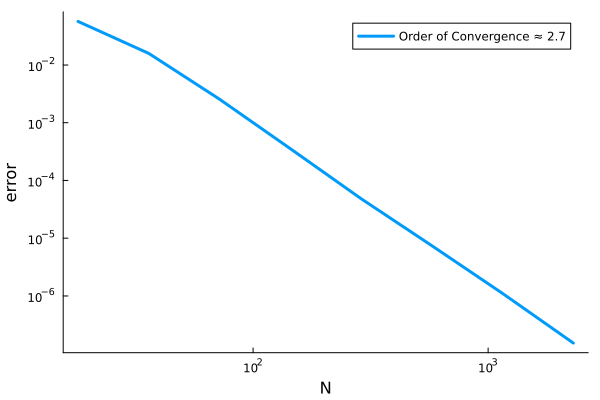

In [11]:
# Convergence Study in time for the two-level Reference Solution

X = 40 # number of (interior) spatial grid points
tspan = [0 1.0]
dx = 1.0 / (X + 1)
x = (1:X) .* dx
u0 = exp.(-200*(x .- 0.25).^2)

K = 9
err = zeros(K-1)  # we will compare successive solutions
nstore = zeros(K-1, 1)
u_store = zeros(X, K)

for k in 1:K
    
    N = 9* 2^k  # number of time intervals
    #nstore[k]= N
    dt = (tspan[2] - tspan[1]) / N
    
    dim, U =L3m3_Dif(dx, u0, N)
    
    # Store only the final state for each k
    u_store[:, k] = U[:, end, end]
end

# Calculate errors
for k in 2:K
    err[k-1] = norm(u_store[:, k] - u_store[:, k-1]) + 10^(-16)
    nstore[k-1] = 9*2^(k-1)  # Store N values for analysis
end

# Polyfit
pdeg = polyfit(log10.(nstore[:]),log10.(err[:]),1)
print("convergence order = ",abs(pdeg[2]), "\n")
convergence_order = abs(pdeg[2])
plot(nstore, err[:], xaxis=:log, yaxis=:log, xlabel="N", ylabel="error", 
     label="Order of Convergence ≈ $(round(convergence_order, digits=2))", linewidth=3, grid=false)
savefig("L3m3-advection-convergence-rate.png")
display(plot!(legend=:topright))

convergence order = 2.6993604636728215


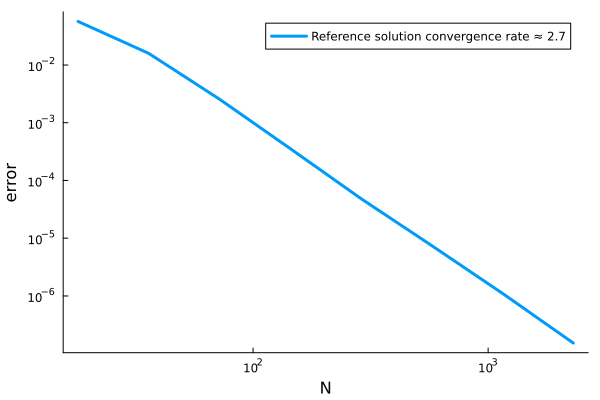

In [17]:
pdeg = polyfit(log10.(nstore[:]),log10.(err[:]),1)
print("convergence order = ",abs(pdeg[2]), "\n")
convergence_order = abs(pdeg[2])
plot(nstore, err[:], xaxis=:log, yaxis=:log, xlabel="N", ylabel="error", 
     label="Reference solution convergence rate ≈ $(round(convergence_order, digits=2))", linewidth=3, grid=false)
savefig("L3m3-advection-convergence-rate.png")
display(plot!(legend=:topright))